# SETUP

In [11]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes
## for statistical tests
import scipy
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
# from lime import lime_tabular
import matplotlib.ticker as plticker
import pickle
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
#Predit on the test set
dfs = pd.read_csv("train.csv")
dfs.head()

Id  Marital status  Application mode  Application order  Course  \
0  3222               1                 1                  1      14   
1  2388               1                 8                  4       9   
2  1865               1                12                  1      17   
3   652               1                12                  1      12   
4  4220               1                 1                  1      14   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           0                       1            1   
3                           1                      12            1   
4                           1                       1            1   

   Mother's qualification  Father's qualification  ...  \
0                      13                      28  ...   
1                      23                      14  ...   
2                       1                       1  ...   
3                       1                       5  ...   
4                      19                      28  ...   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    6   
1                                    0                                    5   
2                                    0                                    5   
3                                    0                                    8   
4                                    0                                    5   

   Curricular units 2nd sem (evaluations)  \
0                                       7   
1                                      10   
2                                       5   
3                                      11   
4                                       5   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    6                         14.714286   
1                                    2                         12.500000   
2                                    5                         12.400000   
3                                    7                         12.614286   
4                                    0                          0.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               11.1   
1                                               0               11.1   
2                                               0               15.5   
3                                               0               12.7   
4                                               0                9.4   

   Inflation rate   GDP  Category  
0             0.6  2.02  Graduate  
1             0.6  2.02   Dropout  
2             2.8 -4.06  Graduate  
3             3.7 -1.70  Graduate  
4            -0.8 -3.12   Dropout  

[5 rows x 36 columns]

# PREPROCESS

In [13]:
#ENCODING

dfs = pd.get_dummies(dfs, columns=['Marital status'])
dfs = pd.get_dummies(dfs, columns=['Application mode'])
dfs = pd.get_dummies(dfs, columns=['Course'])
dfs = pd.get_dummies(dfs, columns=['Previous qualification'])
dfs = pd.get_dummies(dfs, columns=['Nacionality'])
dfs = pd.get_dummies(dfs, columns=["Mother's occupation"])
dfs = pd.get_dummies(dfs, columns=["Father's occupation"])

#DROP AND CREATE
dfs = dfs.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfs["valid_enroll_sem2"] = dfs["Curricular units 2nd sem (enrolled)"] - dfs["Curricular units 2nd sem (approved)"]
dfs["valid_enroll_sem1"] = dfs["Curricular units 1st sem (enrolled)"] - dfs["Curricular units 1st sem (approved)"]
dfs["gap_enroll_valid"] = dfs["valid_enroll_sem1"] - dfs["valid_enroll_sem2"]


#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfs.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfs.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfs["Category"]
dtf_scaled["Id"] = dfs["Id"]
dfs = dtf_scaled
df = dfs

#features selection
df = dfs[["Id", 
"valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate",
"Category"]]

# PLOTS

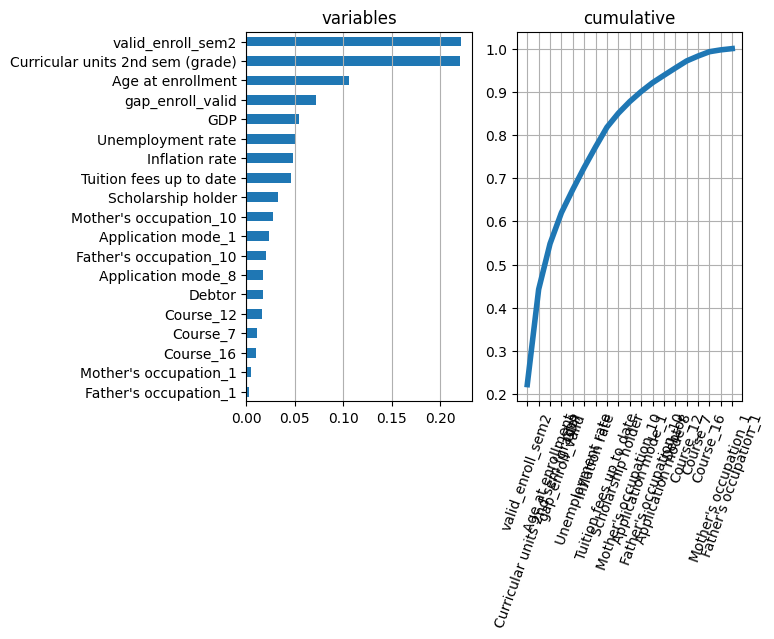

IMPORTANCE    cumsum
VARIABLE                                              
valid_enroll_sem2                   0.221968  0.221968
Curricular units 2nd sem (grade)    0.220577  0.442546
Age at enrollment                   0.105711  0.548257
gap_enroll_valid                    0.071772  0.620028
GDP                                 0.053857  0.673886
Unemployment rate                   0.050834  0.724720
Inflation rate                      0.047745  0.772465
Tuition fees up to date             0.045552  0.818017
Scholarship holder                  0.032342  0.850359
Mother's occupation_10              0.026954  0.877313
Application mode_1                  0.023180  0.900492
Father's occupation_10              0.020468  0.920960
Application mode_8                  0.017167  0.938127
Debtor                              0.016872  0.954999
Course_12                           0.016468  0.971467
Course_7                            0.011345  0.982812
Course_16                           0.010007  0.992819
Mother's occupation_1               0.004311  0.997130
Father's occupation_1               0.002870  1.000000

In [14]:
# Plot
X = df.drop(["Category", "Id"], axis=1).values
y = df["Category"].values
feature_names = df.drop(["Category", "Id"], axis=1).columns

model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas df
dfs_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False).nlargest(30,"IMPORTANCE")
dfs_importances['cumsum'] = dfs_importances['IMPORTANCE'].cumsum(axis=0)
dfs_importances = dfs_importances.set_index("VARIABLE")
    
## Plot

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].title.set_text('variables')
dfs_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dfs_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dfs_importances)), xticklabels=dfs_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()
dfs_importances.head(40)

<AxesSubplot: xlabel='selection', ylabel='features'>

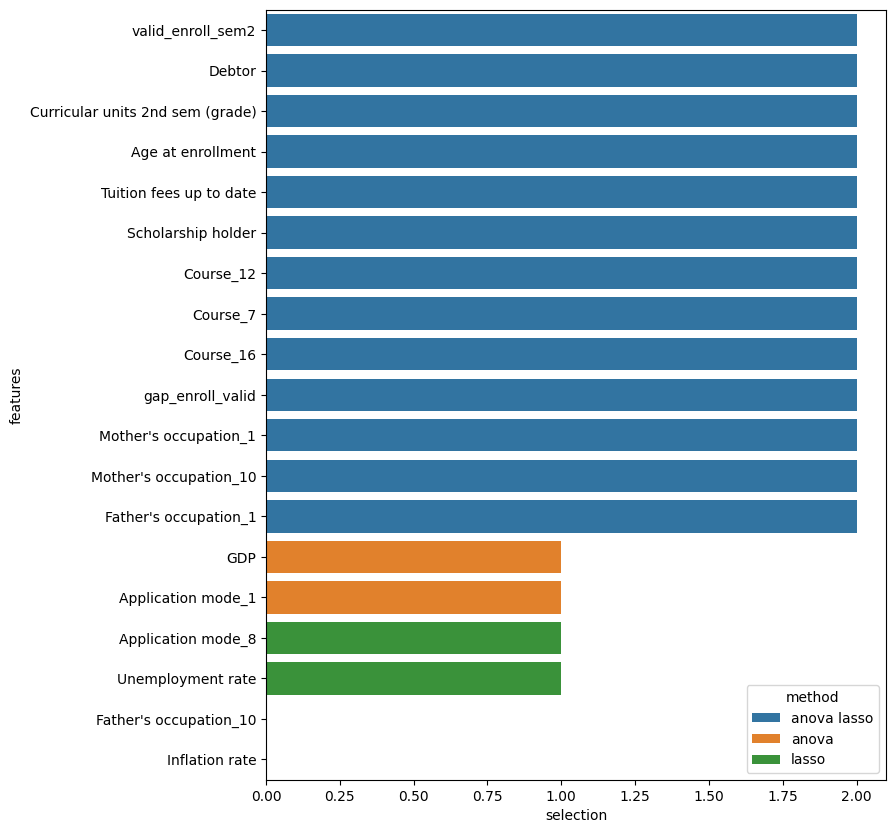

In [15]:
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=15).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=15).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
plt.figure(figsize=(8,10))
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

Text(0.5, 1.0, 'pearson correlation')

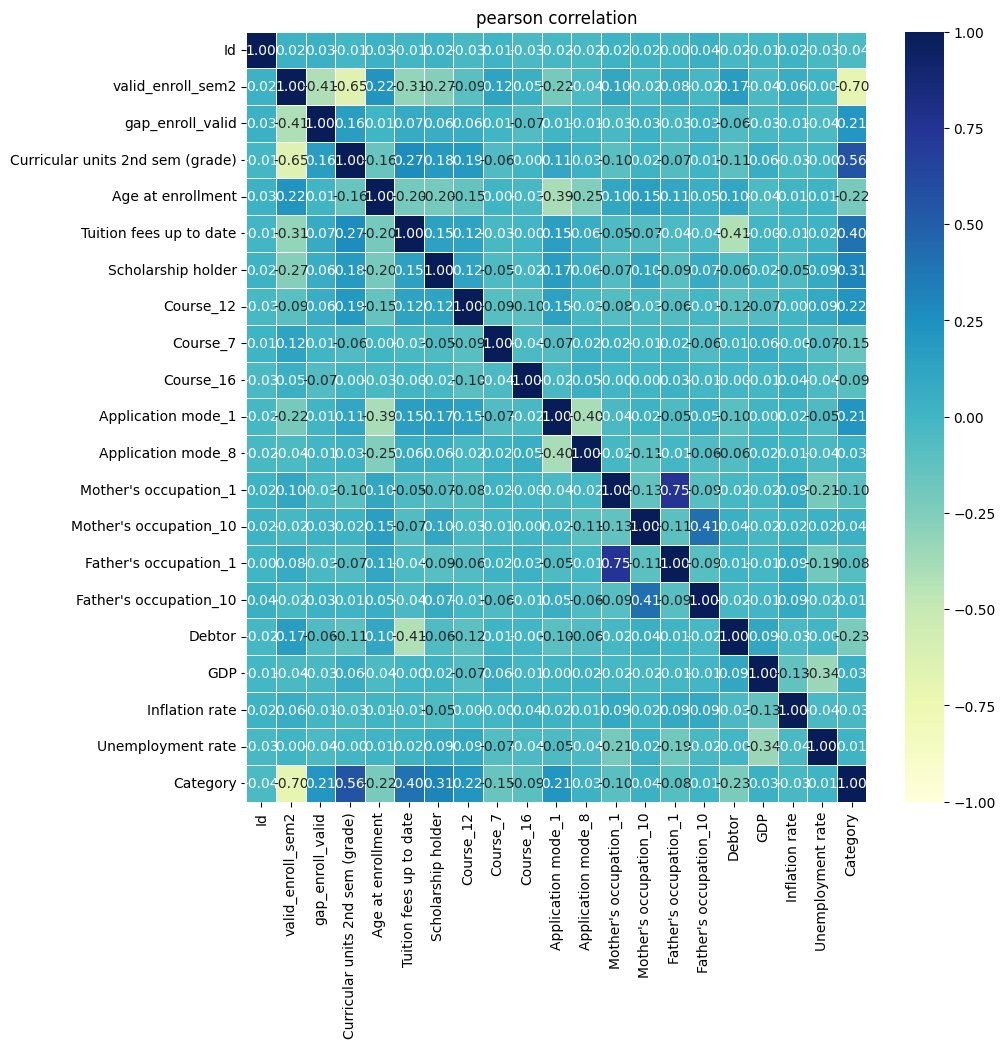

In [16]:
corr_matrix = df.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

# TRAIN MODEL

In [18]:
X_names = ["valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate"
]

X_train = dfs[X_names].values
y_train = dfs["Category"]

y_train = y_train.replace(['Dropout', 'Enrolled', 'Graduate'],[0,1,2]).values

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

## Validation test

In [19]:
# save the model to disk
filename = 'finalized_model_academic_V8.sav'
pickle.dump(model, open(filename, 'wb'))

In [20]:
# validation

dfv = pd.read_csv("validation.csv")
#ENCODING
dfv = pd.get_dummies(dfv, columns=['Marital status'])
dfv = pd.get_dummies(dfv, columns=['Application mode'])
dfv = pd.get_dummies(dfv, columns=['Course'])
dfv = pd.get_dummies(dfv, columns=['Previous qualification'])
dfv = pd.get_dummies(dfv, columns=['Nacionality'])
dfv = pd.get_dummies(dfv, columns=["Mother's occupation"])
dfv = pd.get_dummies(dfv, columns=["Father's occupation"])

#DROP AND CREATE
dfv = dfv.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfv["valid_enroll_sem2"] = dfv["Curricular units 2nd sem (enrolled)"] - dfv["Curricular units 2nd sem (approved)"]
dfv["valid_enroll_sem1"] = dfv["Curricular units 1st sem (enrolled)"] - dfv["Curricular units 1st sem (approved)"]
dfv["gap_enroll_valid"] = dfv["valid_enroll_sem1"] - dfv["valid_enroll_sem2"]

#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfv.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfv.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfv["Category"]
dtf_scaled["Id"] = dfv["Id"]
dfv = dtf_scaled

#features selection
dfv = dfv[["Id",
"valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate",
"Category"]]

#Validation score see

X_validation = dfv[[
"valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate"
]].values
y_validation = dfv["Category"]
y_validation = y_validation.replace(['Dropout', 'Enrolled', 'Graduate'],[0,1,2]).values

loaded_model = pickle.load(open("finalized_model_academic_V8.sav", 'rb'))

# make predictions for test data
y_pred = model.predict(X_validation)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_validation, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
result = loaded_model.score(X_validation, y_validation)
print(result)


Accuracy: 76.05%
0.7605421686746988


## K-fold test accuracy

In [21]:
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X_validation, y_validation):
    X_validation_fold, x_test_fold = X_validation[train_index], X_validation[test_index]
    y_validation_fold, y_test_fold = y_validation[train_index], y_validation[test_index]
    model.fit(X_validation_fold, y_validation_fold)
    lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.6917293233082706, 0.706766917293233, 0.7744360902255639, 0.7142857142857143, 0.706766917293233, 0.7593984962406015, 0.7443609022556391, 0.7142857142857143, 0.6742424242424242, 0.7272727272727273]

Maximum Accuracy That can be obtained from this model is: 77.44360902255639 %

Minimum Accuracy: 67.42424242424242 %

Overall Accuracy: 72.13545226703121 %

Standard Deviation is: 0.03064501084503467
